In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt    
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold

In [2]:
train_train_df = pd.read_csv("train_93_95.csv", sep=",")
train_test_df = pd.read_csv("train_96.csv", sep=",")
train_df = pd.read_csv("train.csv", sep=",")
test_df = pd.read_csv("test.csv", sep=",")

# removing correlated features with corr>0.98
correlated_features = set()
correlation_matrix = train_df.corr()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.98:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
train_df.drop(columns=correlated_features, axis=1, inplace=True)
test_df.drop(columns=correlated_features, axis=1, inplace=True)

In [3]:
unwanted_features = ["status", "loan_id"]
features = [x for x in list(train_df) if x not in unwanted_features]
target = "status"

X = train_df[features]
y = train_df[target]

X_test = train_test_df[features]
y_test = train_test_df[target]

X, X_test, y, y_test = train_test_split(X, y, test_size=0.2)

## Function to train a model using Grid Search Cross Validation

In [4]:
def train_model(X, y, classifier, param_grid, cv=5):
#     # define model evaluation method
#     cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    
    grid = GridSearchCV(estimator=classifier, 
                        param_grid=param_grid, 
                        n_jobs=-1, 
                        cv=cv, 
                        scoring='roc_auc',
                        verbose=2, 
                        refit=True)
    
    grid = grid.fit(X, y)
    print("Best Score:", grid.best_score_)
    print("Best Params:", grid.best_params_)
    
    return grid.best_estimator_

## Function to Evaluate the Model with AUC and Confusion Matrix

In [5]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict_proba(X_test)
    
    # Area Under the Curve, the higher the better
    auc = metrics.roc_auc_score(y_test, y_pred[:,-1])
    print("AUC Score: ", auc)

    y_pred_normalized = np.argmax(model.predict_proba(X_test), axis=1)

    cm = metrics.confusion_matrix(y_test, y_pred_normalized)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['yes', 'no']); ax.yaxis.set_ticklabels(['yes', 'no']);
    
    return y_pred[:,-1]

## Function to export the test predicted data

In [6]:
def test_export(model, test_df, file):
    test = test_df[features]

    confidences = model.predict_proba(test)[:,-1]

    confidences = [0 if x < 0.000001 else x for x in confidences]
    confidences = ["{:f}".format(x) for x in confidences]

    submit = pd.DataFrame()

    submit["Id"] = test_df["loan_id"]
    submit["Predicted"] = confidences

    submit.to_csv(file + ".csv", sep=",", index=False)
    
    return "Done exporting to: " + file + ".csv"

# Model Training

## 1. Random Forest Classifier

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Score: 0.8390746753246752
Best Params: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
AUC Score:  0.7887931034482759


'Done exporting to: rfc_submit.csv'

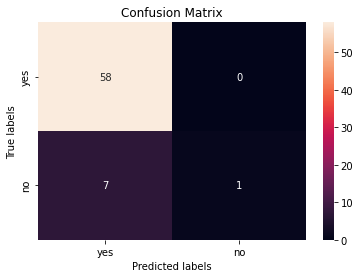

In [7]:
rfc = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [100, 150],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [8,9,10,11,12],
    'criterion' :['gini', 'entropy'],
    'bootstrap': [True],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2,3],
}

model = train_model(X, y, rfc, param_grid, cv=5)

y_pred_rfc = evaluate(model, X_test, y_test)

test_export(model, test_df, "rfc_submit")

## 2. SVM Classifier

In [ ]:
svm = SVC(probability=True)

param_grid = {'C': [1, 10, 50, 100],
              'gamma': [0.5, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['poly'],
               'degree': [1, 2]}
 
model = train_model(X, y, svm, param_grid)
 
y_pred_svm = evaluate(model, X_test, y_test)
    
test_export(model, test_df, "svm_submit")

## 3. XGBoost Classifier

Fitting 4 folds for each of 144 candidates, totalling 576 fits
Best Score: 0.7955357142857142
Best Params: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'missing': -999, 'n_estimators': 1000, 'objective': 'binary:logistic', 'seed': 46, 'subsample': 0.9}
AUC Score:  0.6875


'Done exporting to: xgb_submit.csv'

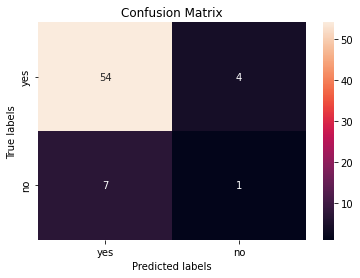

In [8]:
xgb = xgb.XGBClassifier(use_label_encoder=False,eval_metric='auc')

param_grid = {#'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.1, 0.25],
              'max_depth': [5,6,8,10],
              'min_child_weight': [10, 5, 6],
              'subsample': [0.85, 0.8, 0.9],
              'colsample_bytree': [0.8, 0.9],
              'n_estimators': [1000],
              'missing':[-999],
              'seed': [46]}

model = train_model(X, y, xgb, param_grid, cv=4)

y_pred_xgb = evaluate(model, X_test, y_test)

test_export(model, test_df, "xgb_submit")

## 4. Neural Network

In [10]:
from keras.models import Sequential
from keras.layers import Dense
import keras

X = train_train_df[features]
y = train_train_df[target]

# define the keras model
model = Sequential()
model.add(Dense(32, input_dim=42, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras.metrics.AUC()])
# fit the keras model on the dataset
model.fit(X, y, epochs=300, batch_size=32, verbose=0)
# evaluate the keras model
_, auc = model.evaluate(X, y)
print('AUC: %.2f' % auc)


7/7 [==============================] - 0s 429us/step - loss: 1.1522 - auc_1: 0.9305
AUC: 0.93


Instructions for updating:
Please use `model.predict()` instead.
AUC Score:  0.9137931034482759


'Done exporting to: neural_network_submit.csv'

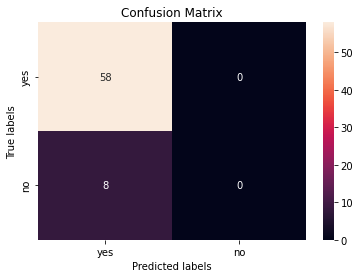

In [11]:
y_pred_neural = evaluate(model, X_test, y_test)

test_export(model, test_df, "neural_network_submit")

## 5. K Nearest Neighbors

Fitting 20 folds for each of 30 candidates, totalling 600 fits
Best Score: 0.7183333333333334
Best Params: {'n_neighbors': 27}
AUC Score:  0.5818965517241379


'Done exporting to: knn_submit.csv'

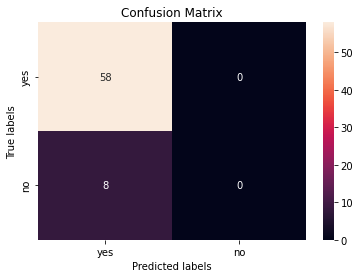

In [12]:
knn = KNeighborsClassifier()

param_grid = dict(n_neighbors=list(range(1, 31)))
  
model = train_model(X, y, knn, param_grid, cv=20)

y_pred_knn = evaluate(model, X_test, y_test)

test_export(model, test_df, "knn_submit")

## 6. Decision Tree Classifier

Fitting 5 folds for each of 1520 candidates, totalling 7600 fits
Best Score: 0.7888763763763764
Best Params: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 3}
AUC Score:  0.8987068965517242


'Done exporting to: dtc_submit.csv'

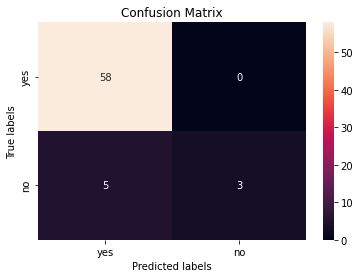

In [13]:
dtc = DecisionTreeClassifier()

param_grid = {'criterion': ['gini', 'entropy'],
             'max_depth': range(1,20),
             'min_samples_split': range(2,10),
             'min_samples_leaf': range(1,6)}

model = train_model(X, y, dtc, param_grid, cv=5)

y_pred_dtc = evaluate(model, X_test, y_test)

test_export(model, test_df, "dtc_submit")

## 7. Gaussian Process Classifier

Best Mean Accuracy: 0.700
Best Config: {'kernel': 1**2 * RationalQuadratic(alpha=1, length_scale=1)}
>0.500 with: {'kernel': 1**2 * RBF(length_scale=1)}
>nan with: {'kernel': 1**2 * DotProduct(sigma_0=1)}
>0.500 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
>0.700 with: {'kernel': 1**2 * RationalQuadratic(alpha=1, length_scale=1)}
>0.500 with: {'kernel': 1**2 * WhiteKernel(noise_level=1)}
AUC Score:  0.9310344827586207


C:\Users\gonca\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
13 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\gonca\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\gonca\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpc.py", line 715, in fit
    self.base_estimator_.fit(X, y)
  File "C:\Users\gonca\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpc.py", line 224, in fit
    self._constrained_optimization(
  File "C:\Users\gonca\anaconda3\

'Done exporting to: gp_submit.csv'

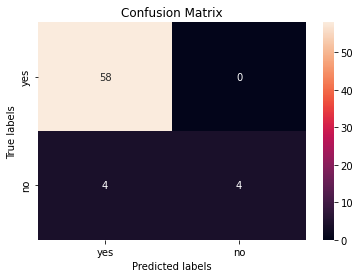

In [14]:

# grid search kernel for gaussian process classifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel

# define model
model = GaussianProcessClassifier()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['kernel'] = [1*RBF(), 1*DotProduct(), 1*Matern(),  1*RationalQuadratic(), 1*WhiteKernel()]
# define search
search = GridSearchCV(model, grid, scoring='roc_auc', cv=cv, n_jobs=-1, refit=True)
# perform the search
results = search.fit(X, y)
# summarize best
print('Best Mean Accuracy: %.3f' % results.best_score_)
print('Best Config: %s' % results.best_params_)
# summarize all
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(">%.3f with: %r" % (mean, param))
    

model = results.best_estimator_

y_pred_gp = evaluate(model, X_test, y_test)

test_export(model, test_df, "gp_submit")

## 8. MLP Classifier

Fitting 5 folds for each of 35 candidates, totalling 175 fits
Best Score: 0.6691191191191191
Best Params: {'alpha': 0.75, 'hidden_layer_sizes': 20}
AUC Score:  0.5355603448275863


'Done exporting to: mlp_submit.csv'

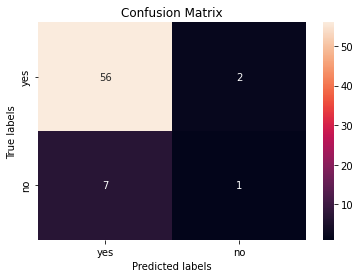

In [15]:
mlp = MLPClassifier(alpha=1, hidden_layer_sizes=150)

param_grid = {'alpha': [0.1, 0.25, 0.45, 0.5, 0.55, 0.75, 0.85],
             'hidden_layer_sizes': [10, 20, 30, 60, 100]}

model = train_model(X, y, mlp, param_grid)

y_pred_mlp = evaluate(model, X_test, y_test)

test_export(model, test_df, "mlp_submit")

# Compare ROCs

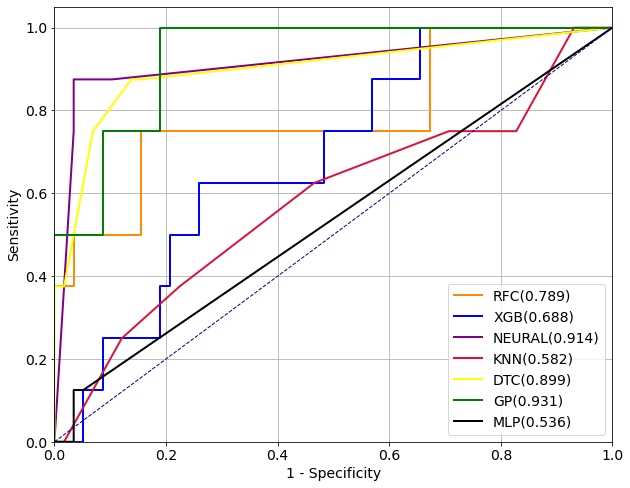

In [17]:
import numpy as np
np.random.seed(2018)

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib
import matplotlib.pyplot as plt

def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc


plt.figure(figsize=(10, 8))
matplotlib.rcParams.update({'font.size': 14})
plt.grid()

fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_pred_rfc)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='RFC({0:.3f})'.format(roc_auc))

# fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_pred_svm)
# plt.plot(fpr, tpr, color='red', lw=2, label='SVM({0:.3f})'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_pred_xgb)
plt.plot(fpr, tpr, color='blue', lw=2, label='XGB({0:.3f})'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_pred_neural)
plt.plot(fpr, tpr, color='purple', lw=2, label='NEURAL({0:.3f})'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_pred_knn)
plt.plot(fpr, tpr, color='crimson', lw=2, label='KNN({0:.3f})'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_pred_dtc)
plt.plot(fpr, tpr, color='yellow', lw=2, label='DTC({0:.3f})'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_pred_gp)
plt.plot(fpr, tpr, color='green', lw=2, label='GP({0:.3f})'.format(roc_auc))

fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_pred_mlp)
plt.plot(fpr, tpr, color='black', lw=2, label='MLP({0:.3f})'.format(roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.show()